# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print(tf.__version__)

2.18.0


# Import Data

In [ ]:
data = 'data/garbage-classification-v2/garbage-dataset'

# Display Data

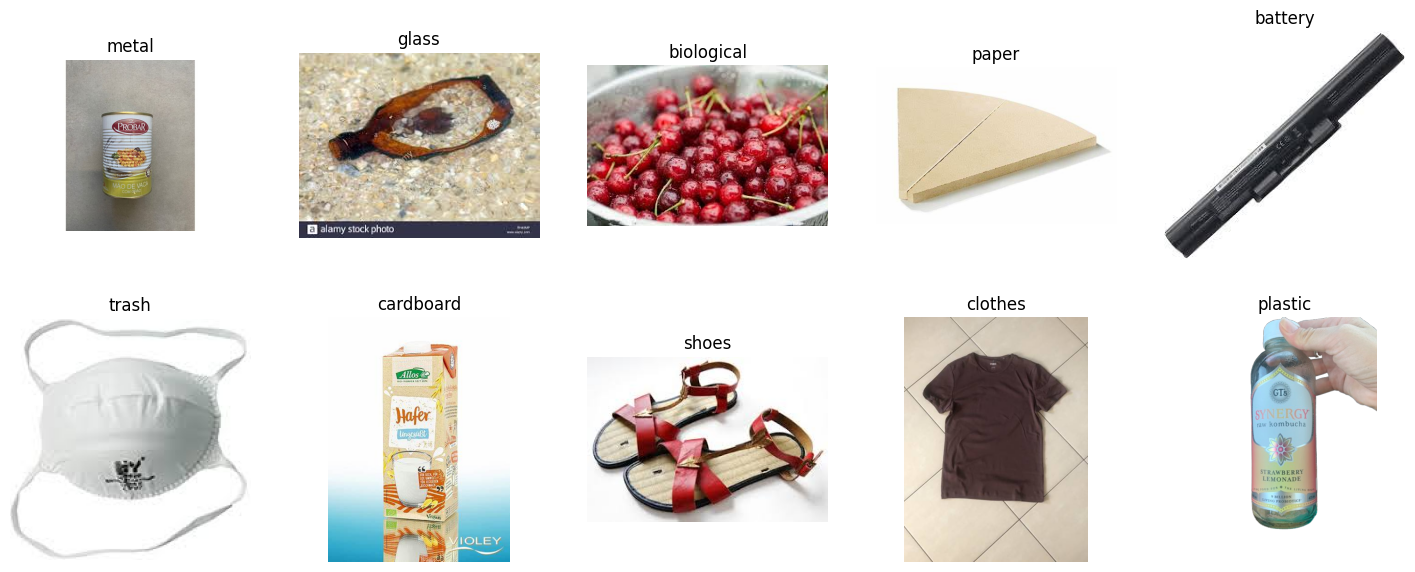

In [4]:
plt.figure(figsize = (18,7))

categorise = os.listdir(data)
for i, category in enumerate(categorise):
    category_path = os.path.join(data, category)
    image = os.listdir(category_path)[0]
    image_path = os.path.join(category_path, image)
    read_image = plt.imread(image_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(read_image)
    plt.title(category)
    plt.axis('off')

plt.show()

# split data (Train, Valid, Test)

In [5]:
from sklearn.model_selection import train_test_split
classes = os.listdir(data)

image_paths = []
labels = []

for class_name in classes:
    class_path = os.path.join(data, class_name)
    for fname in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, fname))
        labels.append(class_name)

df = pd.DataFrame({
    'filename': image_paths,
    'class': labels
})

df

,filename,class
0,/kaggle/input/garbage-dataset/metal/metal_1617...,metal
1,/kaggle/input/garbage-dataset/metal/metal_1809...,metal
2,/kaggle/input/garbage-dataset/metal/metal_2658...,metal
3,/kaggle/input/garbage-dataset/metal/metal_2127...,metal
4,/kaggle/input/garbage-dataset/metal/metal_2152...,metal
...,...,...
19757,/kaggle/input/garbage-dataset/plastic/plastic_...,plastic
19758,/kaggle/input/garbage-dataset/plastic/plastic_...,plastic
19759,/kaggle/input/garbage-dataset/plastic/plastic_...,plastic
19760,/kaggle/input/garbage-dataset/plastic/plastic_...,plastic


In [6]:
train, temp = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
valid, test = train_test_split(temp, test_size=0.3, stratify=temp['class'], random_state=42)


In [7]:
test

,filename,class
4054,/kaggle/input/garbage-dataset/glass/glass_3313...,glass
19098,/kaggle/input/garbage-dataset/plastic/plastic_...,plastic
2552,/kaggle/input/garbage-dataset/glass/glass_2580...,glass
19359,/kaggle/input/garbage-dataset/plastic/plastic_...,plastic
13706,/kaggle/input/garbage-dataset/clothes/clothes_...,clothes
...,...,...
8370,/kaggle/input/garbage-dataset/trash/trash_2024...,trash
7883,/kaggle/input/garbage-dataset/trash/trash_628.jpg,trash
6335,/kaggle/input/garbage-dataset/paper/paper_675.jpg,paper
11440,/kaggle/input/garbage-dataset/shoes/shoes_943.jpg,shoes


In [8]:
valid

,filename,class
3044,/kaggle/input/garbage-dataset/glass/glass_511.jpg,glass
9641,/kaggle/input/garbage-dataset/cardboard/cardbo...,cardboard
14332,/kaggle/input/garbage-dataset/clothes/clothes_...,clothes
364,/kaggle/input/garbage-dataset/metal/metal_2554...,metal
7217,/kaggle/input/garbage-dataset/battery/battery_...,battery
...,...,...
10023,/kaggle/input/garbage-dataset/cardboard/cardbo...,cardboard
17707,/kaggle/input/garbage-dataset/clothes/clothes_...,clothes
9751,/kaggle/input/garbage-dataset/cardboard/cardbo...,cardboard
2411,/kaggle/input/garbage-dataset/glass/glass_4098...,glass


# Data Generator

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    brightness_range=(0.8, 1.2),
    channel_shift_range=20.0,
    fill_mode='nearest'


)
test_valid_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [10]:
train_ds = train_datagen.flow_from_dataframe(
    train,
    x_col='filename',
    y_col='class',
    target_size = (128, 128),
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical'
)

valid_ds = test_valid_datagen.flow_from_dataframe(
    valid,
    x_col='filename',
    y_col='class',
    target_size = (128,128),
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical'
)

test_ds = test_valid_datagen.flow_from_dataframe(
    test,
    x_col='filename',
    y_col='class',
    target_size = (128, 128),
    seed = 42,
    batch_size = 32,
    shuffle = True,
    class_mode = 'categorical'
)

Found 13833 validated image filenames belonging to 10 classes.
Found 4150 validated image filenames belonging to 10 classes.
Found 1779 validated image filenames belonging to 10 classes.


In [11]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("Physical:", tf.config.list_physical_devices())
print("Logical:", tf.config.list_logical_devices())


TF Version: 2.18.0
Physical: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Logical: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


I0000 00:00:1764840136.342168      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764840136.342815      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Structure Model

In [12]:


# 在 TPU 策略作用域中创建和编译模型
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,681,258 (33.12 MB)

 Trainable params: 8,679,850 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [13]:
callbacks = [
    EarlyStopping(
        monitor = 'val_accuracy',
        patience = 50,
        restore_best_weights = True
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.2,
        patience = 30,
        min_lr = 0.0001
    ),
]

# Class_Weight

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_names = sorted(train['class'].unique())
class_to_index = {name: idx for idx, name in enumerate(class_names)}
y_train = train['class'].map(class_to_index)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 2.0927382753403934,
 1: 1.9818051575931233,
 2: 1.083241973375098,
 3: 0.37095736122284795,
 4: 0.6457983193277311,
 5: 1.9373949579831933,
 6: 1.1762755102040816,
 7: 0.9958963282937365,
 8: 0.9994942196531792,
 9: 2.086425339366516}

# Fitting

In [15]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 100,
    callbacks = callbacks,
    verbose = 1,
    class_weight=class_weights_dict
)

Epoch 1/100


I0000 00:00:1764840145.751373     105 service.cc:148] XLA service 0x7993100082d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764840145.752483     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764840145.752501     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764840146.520960     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/433 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.0234 - loss: 4.7225       

I0000 00:00:1764840156.191833     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 205s 433ms/step - accuracy: 0.2655 - loss: 2.4734 - val_accuracy: 0.4072 - val_loss: 1.7432 - learning_rate: 0.0010
Epoch 2/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 110s 254ms/step - accuracy: 0.4241 - loss: 1.7821 - val_accuracy: 0.4687 - val_loss: 1.6049 - learning_rate: 0.0010
Epoch 3/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 108s 250ms/step - accuracy: 0.4789 - loss: 1.5275 - val_accuracy: 0.4429 - val_loss: 1.8187 - learning_rate: 0.0010
Epoch 4/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 108s 249ms/step - accuracy: 0.5236 - loss: 1.4085 - val_accuracy: 0.6108 - val_loss: 1.1752 - learning_rate: 0.0010
Epoch 5/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 110s 253ms/step - accuracy: 0.5686 - loss: 1.2957 - val_accuracy: 0.5260 - val_loss: 1.4236 - learning_rate: 0.0010
Epoch 6/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 110s 254ms/step - accuracy: 0.5954 - loss: 1.2080 - val_accuracy: 0.6506 - val_loss: 1.0670 - learning_rate: 0.0010
Epoch 7/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 110s 253ms/step - accuracy: 0

# Evaluate

In [16]:
train_loss, train_acc = model.evaluate(train_ds)
print(f"Train Accuracy: {train_acc * 100:.2f}%")

# Evaluate on validation set
val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

433/433 ━━━━━━━━━━━━━━━━━━━━ 95s 220ms/step - accuracy: 0.9569 - loss: 0.1279
Train Accuracy: 95.75%
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.8665 - loss: 0.5230
Validation Accuracy: 86.80%
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.8735 - loss: 0.5036
Test Accuracy: 86.85%


# plot(Accuracy And Loss)

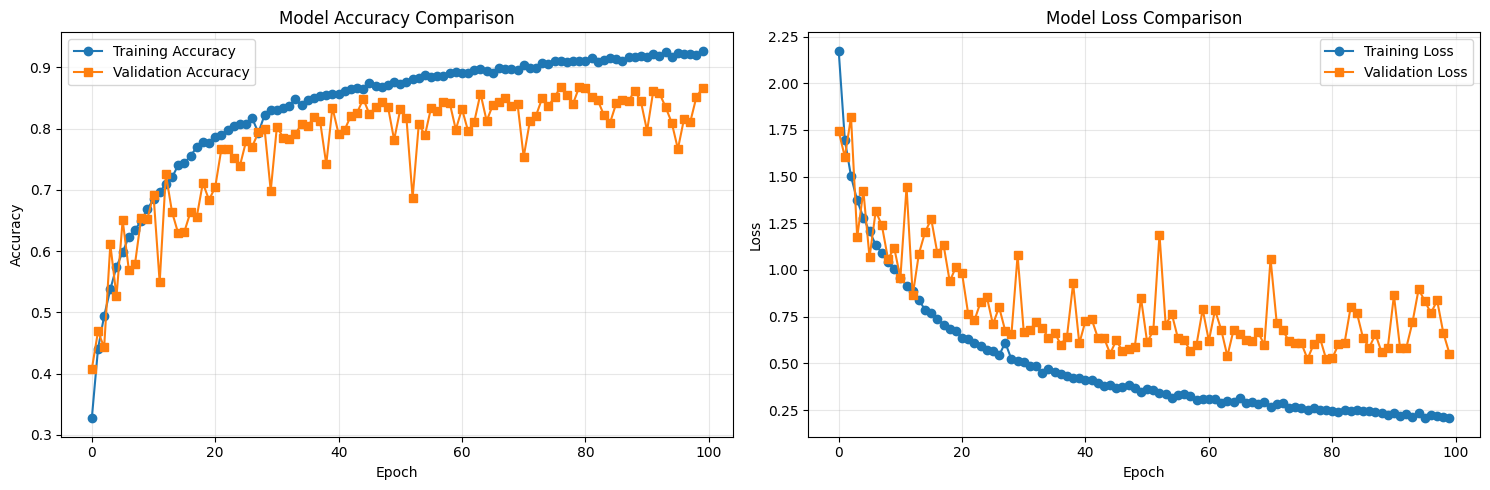

In [17]:
#  Plot Training History - Accuracy
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy', marker = 'o')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', marker = 's')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

#  Plot Training History - Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#  Make Predictions on Test Set

MAKING PREDICTIONS ON TEST SET
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

SAMPLE PREDICTIONS WITH CONFIDENCE
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


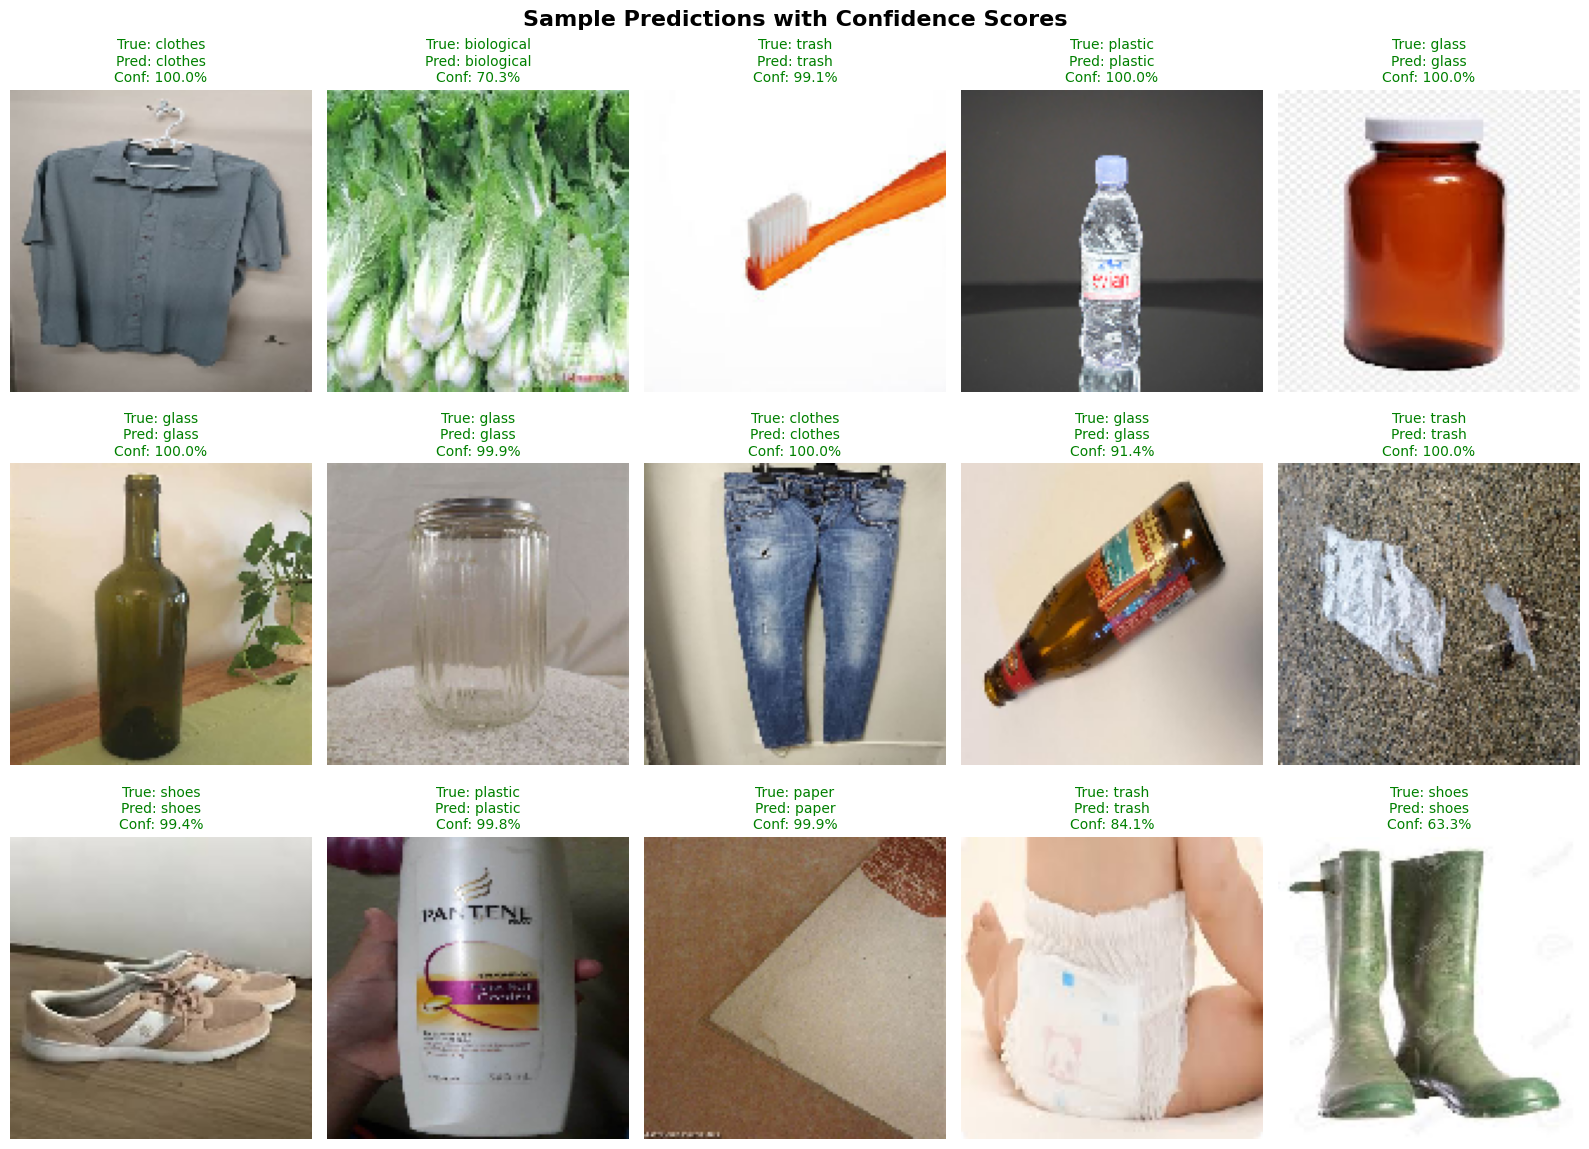


Detailed Predictions (First 10 samples):
✓ Sample  1: True=clothes      | Pred=clothes      | Confidence=100.0%
✓ Sample  2: True=biological   | Pred=biological   | Confidence= 70.3%
✓ Sample  3: True=trash        | Pred=trash        | Confidence= 99.1%
✓ Sample  4: True=plastic      | Pred=plastic      | Confidence=100.0%
✓ Sample  5: True=glass        | Pred=glass        | Confidence=100.0%
✓ Sample  6: True=glass        | Pred=glass        | Confidence=100.0%
✓ Sample  7: True=glass        | Pred=glass        | Confidence= 99.9%
✓ Sample  8: True=clothes      | Pred=clothes      | Confidence=100.0%
✓ Sample  9: True=glass        | Pred=glass        | Confidence= 91.4%
✓ Sample 10: True=trash        | Pred=trash        | Confidence=100.0%


In [18]:
#  Make Predictions on Test Set
print("MAKING PREDICTIONS ON TEST SET")
print("="*50)

# Get predictions
test_predictions = model.predict(test_ds)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get true labels
test_ds.reset()
true_labels = []
for i in range(len(test_ds)):
    batch_labels = test_ds[i][1]
    true_labels.extend(np.argmax(batch_labels, axis=1))
    if i >= len(test_ds) - 1:
        break

true_labels = np.array(true_labels[:len(test_pred_classes)])

# Get class names
class_names = list(test_ds.class_indices.keys())
print(f"Classes: {class_names}")

#  Display Sample Predictions with Confidence
print("\n" + "="*50)
print("SAMPLE PREDICTIONS WITH CONFIDENCE")
print("="*50)

# Get some test images and predictions
test_ds.reset()
sample_batch = next(iter(test_ds))
sample_images, sample_labels = sample_batch
sample_predictions = model.predict(sample_images)
# Display first 15 predictions
plt.figure(figsize=(16, 12))
for i in range(min(15, len(sample_images))):
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_images[i])

    true_class = class_names[np.argmax(sample_labels[i])]
    pred_class = class_names[np.argmax(sample_predictions[i])]
    confidence = np.max(sample_predictions[i]) * 100

    color = 'green' if true_class == pred_class else 'red'
    plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%',
              color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed predictions for first few samples
print("\nDetailed Predictions (First 10 samples):")
for i in range(min(10, len(sample_predictions))):
    true_class = class_names[np.argmax(sample_labels[i])]
    pred_class = class_names[np.argmax(sample_predictions[i])]
    confidence = np.max(sample_predictions[i]) * 100

    status = "✓" if true_class == pred_class else "✗"
    print(f"{status} Sample {i+1:2d}: True={true_class:12s} | Pred={pred_class:12s} | Confidence={confidence:5.1f}%")

# Classification Report

In [19]:
# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

try:
    report = classification_report(true_labels, test_pred_classes,
                                 target_names=class_names, digits=3)
    print(report)
except:
    print("sklearn not available, showing manual classification metrics:")

    # Manual classification metrics
    from collections import defaultdict

    metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})

    for true_label, pred_label in zip(true_labels, test_pred_classes):
        if true_label == pred_label:
            metrics[true_label]['tp'] += 1
        else:
            metrics[pred_label]['fp'] += 1
            metrics[true_label]['fn'] += 1

    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)

    total_support = 0
    weighted_precision = 0
    weighted_recall = 0
    weighted_f1 = 0

    for i, class_name in enumerate(class_names):
        tp = metrics[i]['tp']
        fp = metrics[i]['fp']
        fn = metrics[i]['fn']
        support = tp + fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"{class_name:<15} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<10}")

        total_support += support
        weighted_precision += precision * support
        weighted_recall += recall * support
        weighted_f1 += f1 * support

    print("-" * 60)
    print(f"{'Weighted Avg':<15} {weighted_precision/total_support:<10.3f} {weighted_recall/total_support:<10.3f} {weighted_f1/total_support:<10.3f} {total_support:<10}")
    print(f"{'Accuracy':<15} {np.mean(true_labels == test_pred_classes):<10.3f}")


CLASSIFICATION REPORT
sklearn not available, showing manual classification metrics:
Class           Precision  Recall     F1-Score   Support   
------------------------------------------------------------
battery         0.056      0.059      0.057      85        
biological      0.037      0.033      0.035      90        
cardboard       0.072      0.067      0.070      164       
clothes         0.272      0.282      0.277      479       
glass           0.151      0.156      0.154      276       
metal           0.026      0.022      0.024      92        
paper           0.063      0.066      0.065      151       
plastic         0.083      0.084      0.083      179       
shoes           0.108      0.101      0.104      178       
trash           0.032      0.035      0.034      85        
------------------------------------------------------------
Weighted Avg    0.135      0.138      0.136      1779      
Accuracy        0.138     


# Confusion Matrix


CONFUSION MATRIX
sklearn not available, creating manual confusion matrix:


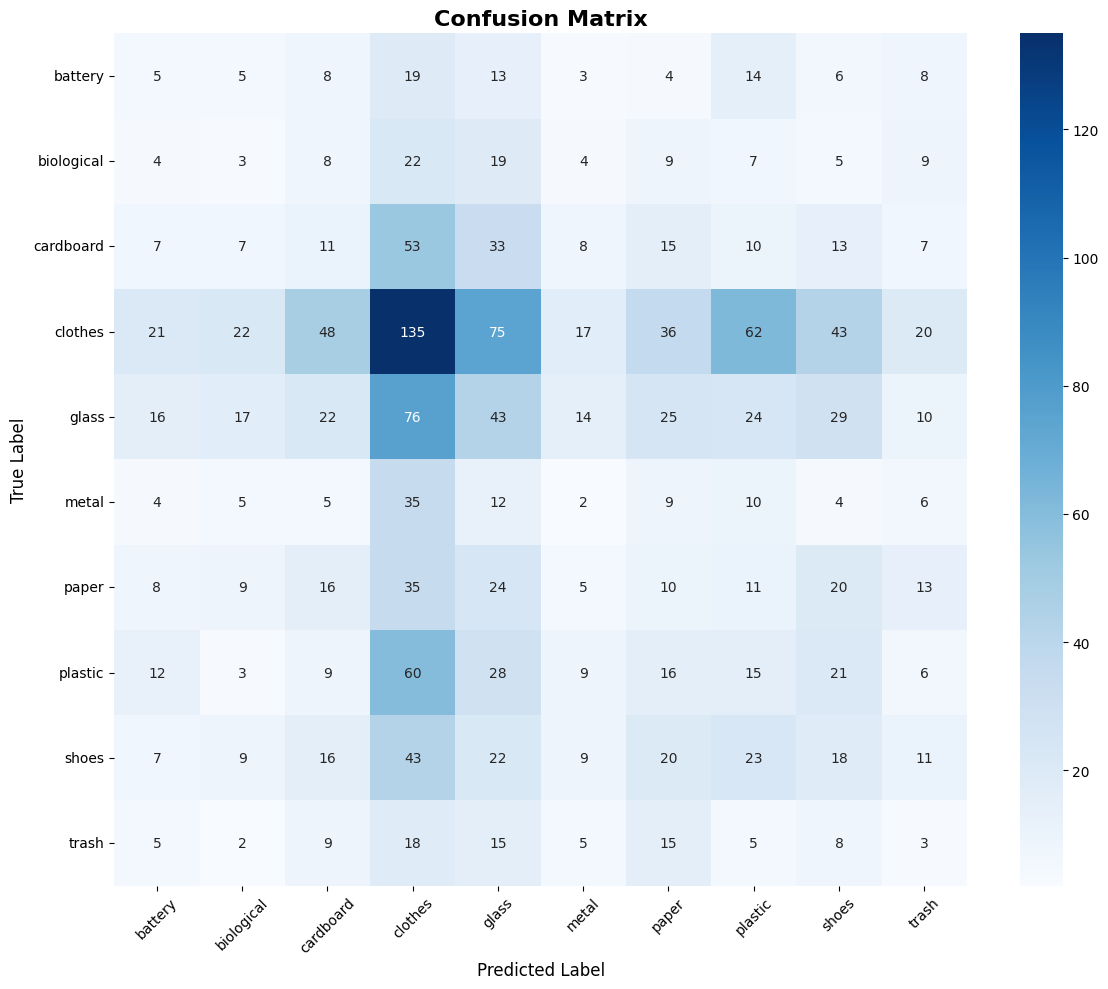

In [20]:
# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

try:
    cm = confusion_matrix(true_labels, test_pred_classes)
except:
    print("sklearn not available, creating manual confusion matrix:")

    # Manual confusion matrix
    n_classes = len(class_names)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for true_label, pred_label in zip(true_labels, test_pred_classes):
        cm[true_label, pred_label] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot per-class accuracy


PER-CLASS ACCURACY
battery        :   5.88% ( 85 samples)
biological     :   3.33% ( 90 samples)
cardboard      :   6.71% (164 samples)
clothes        :  28.18% (479 samples)
glass          :  15.58% (276 samples)
metal          :   2.17% ( 92 samples)
paper          :   6.62% (151 samples)
plastic        :   8.38% (179 samples)
shoes          :  10.11% (178 samples)
trash          :   3.53% ( 85 samples)


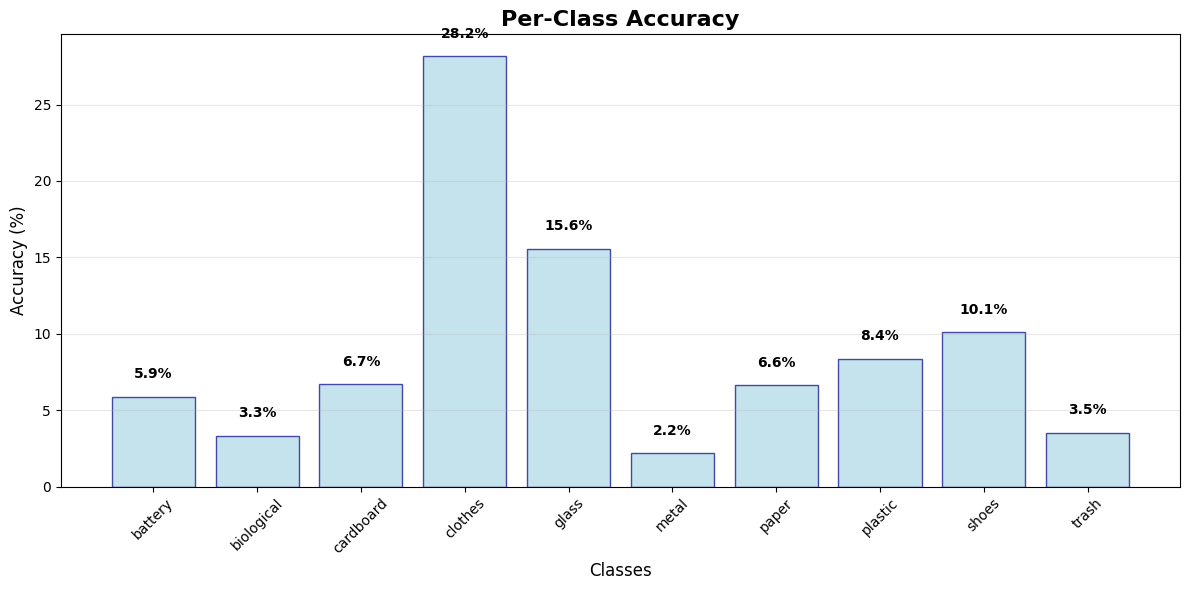


Overall Test Accuracy: 86.85%
Mean Per-Class Accuracy: 9.05%


In [21]:
# Per-class Accuracy
print("\n" + "="*50)
print("PER-CLASS ACCURACY")
print("="*50)

class_accuracies = []
for i in range(len(class_names)):
    class_mask = (true_labels == i)
    if np.sum(class_mask) > 0:
        class_acc = np.sum((test_pred_classes == i) & class_mask) / np.sum(class_mask)
        class_accuracies.append(class_acc)
        print(f"{class_names[i]:15s}: {class_acc*100:6.2f}% ({np.sum(class_mask):3d} samples)")

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_names)), [acc*100 for acc in class_accuracies],
    color='lightblue', edgecolor='navy', alpha=0.7)
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, acc in enumerate(class_accuracies):
    plt.text(i, acc*100 + 1, f'{acc*100:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nOverall Test Accuracy: {test_acc*100:.2f}%")
print(f"Mean Per-Class Accuracy: {np.mean(class_accuracies)*100:.2f}%")